In [24]:
import pandas as pd

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
import lightgbm as lgb

import joblib

In [2]:
# Load the dataset
file_path = "loan-train.csv"
df = pd.read_csv(file_path)

In [3]:
# Display basic information and first few rows
df_info = df.info()
df_head = df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
# Check for missing values
missing_values = df.isnull().sum()

In [5]:
# Check target variable distribution
target_distribution = df['Loan_Status'].value_counts()

In [6]:
df_info, df_head, missing_values, target_distribution

(None,
     Loan_ID Gender Married Dependents     Education Self_Employed  \
 0  LP001002   Male      No          0      Graduate            No   
 1  LP001003   Male     Yes          1      Graduate            No   
 2  LP001005   Male     Yes          0      Graduate           Yes   
 3  LP001006   Male     Yes          0  Not Graduate            No   
 4  LP001008   Male      No          0      Graduate            No   
 
    ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
 0             5849                0.0         NaN             360.0   
 1             4583             1508.0       128.0             360.0   
 2             3000                0.0        66.0             360.0   
 3             2583             2358.0       120.0             360.0   
 4             6000                0.0       141.0             360.0   
 
    Credit_History Property_Area Loan_Status  
 0             1.0         Urban           Y  
 1             1.0         Rural           

In [7]:
# Step 1: EDA and Data Cleaning

# First, let's make a copy of the dataset
data = df.copy()

In [9]:
# Fill missing categorical variables with mode
for column in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    data[column].fillna(data[column].mode()[0], inplace=True)

C:\Users\keval\AppData\Local\Temp\ipykernel_7544\2865999194.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)


In [10]:
# Fill missing numerical variables
data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)

C:\Users\keval\AppData\Local\Temp\ipykernel_7544\785013039.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['LoanAmount'].fillna(data['LoanAmount'].median(), inplace=True)
C:\Users\keval\AppData\Local\Temp\ipykernel_7544\785013039.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [13]:
# Confirm missing values handled
missing_after = data.isnull().sum()

# Show updated missing values check
missing_after

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

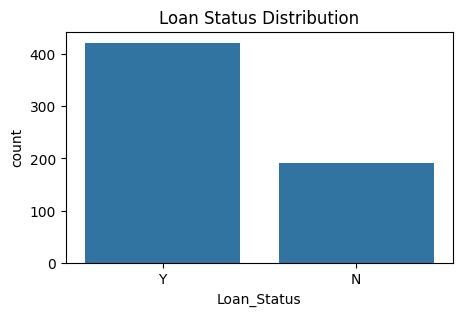

In [12]:
# Plot distribution of target variable
plt.figure(figsize=(5, 3))
sns.countplot(x='Loan_Status', data=data)
plt.title('Loan Status Distribution')
plt.show()

In [15]:
# Step 2: Feature Engineering
data['TotalIncome'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['Loan_to_Income'] = data['LoanAmount'] / data['TotalIncome']

In [16]:
# Drop unnecessary columns
data.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)

In [17]:
# Encode categorical variables using LabelEncoder
categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # save the encoder for possible inverse transform later

# Display the first few rows after processing
data.head()

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,Loan_to_Income
0,1,0,0,0,0,128.0,360.0,1.0,2,1,5849.0,0.021884
1,1,1,1,0,0,128.0,360.0,1.0,0,0,6091.0,0.021015
2,1,1,0,0,1,66.0,360.0,1.0,2,1,3000.0,0.022000
3,1,1,0,1,0,120.0,360.0,1.0,2,1,4941.0,0.024287
4,1,0,0,0,0,141.0,360.0,1.0,2,1,6000.0,0.023500


In [19]:
# Step 1: Split the data
X = data.drop('Loan_Status', axis=1)
y = data['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Step 2: Train Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

C:\Users\keval\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Step 3: Train LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 449
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [22]:
# Step 4: Evaluate Models
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_prob_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

print("\n=== LightGBM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))
print("Classification Report:\n", classification_report(y_test, y_pred_lgb))

=== Logistic Regression ===
Accuracy: 0.7804878048780488
ROC AUC: 0.7459302325581395
Confusion Matrix:
 [[18 25]
 [ 2 78]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123


=== LightGBM ===
Accuracy: 0.7235772357723578
ROC AUC: 0.7302325581395348
Confusion Matrix:
 [[22 21]
 [13 67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.51      0.56        43
           1       0.76      0.84      0.80        80

    accuracy                           0.72       123
   macro avg       0.69      0.67      0.68       123
weighted avg       0.71      0.72      0.72       123



In [25]:
# Save the LightGBM model
joblib.dump(lgb_model, "credit_risk_model.pkl")

['credit_risk_model.pkl']